(simple_linregr)=
# Simple linear regression

We demonstrate in this tutorial how to use BayesBay to tackle a simple linear regression problem: polynomial fitting. In the following, we utilise a third-degree polynomial, $y(x) = m_0 + m_1 x + m_2 x^2 + m_3 x^3$, to generate data points $y_1(x_1), y_2(x_2), \ldots, y_n(x_n)$. In matrix notation, these can be expressed as

$$\underbrace{\left(\begin{array}{c}y_0\\y_1\\\vdots\\y_N\end{array}\right)}_{\text{Data}} = \underbrace{\left(\begin{array}{ccc}1&x_0&x_0^2&x_0^3\\1&x_1&x_1^2&x_1^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)}_{\text{Forward operator or data kernel}} \underbrace{\left(\begin{array}{c}m_0\\m_1\\m_2\\m_3\end{array}\right)}_{\text{Model}},$$

or $\mathbf{d}_{pred} = \mathbf{G m}$. 

Having generated a synthetic data set using the model coefficients $m_0$, $m_1$, $m_2$, and $m_3$, we add noise to define the observed data $\mathbf{d}_{obs} = \mathbf{d}_{pred} + \mathbf{e}$, where the $i$th entry of the observational error $\mathbf{e}$ is randomly sampled from the normal distribution $\mathcal{N}(0, \sigma)$. Finally, we use BayesBay to retrieve the true coefficients from the observations. 

Here we assume that the data noise is known. For a hierarchical example, where the data noise is treated as unknown, please refer to this [tutorial](hierarchical_linregr).

## Import libraries and define constants

In [1]:
import bayesbay as bb
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(30)

In [14]:
# dimensions and true coefficients
N_DIMS = 4
M0, M1, M2, M3 = 20, -10, -3, 1

# data and noise
N_DATA = 15
DATA_X = np.linspace(-5, 10, N_DATA)
DATA_NOISE_STD = 20

## Data predictions and kernel

The following code block defines the forward operator. This is used to throughout the tutorial generate data predictions based on the considered model coefficients.

In [15]:
fwd_operator = np.vander(DATA_X, N_DIMS, True)
y = fwd_operator @ [M0, M1, M2, M3]
y_noisy = y + np.random.normal(0, DATA_NOISE_STD, y.shape)

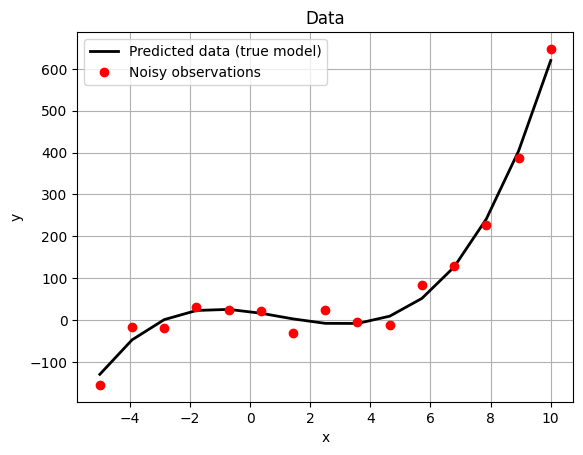

In [16]:
fig, ax = plt.subplots()
ax.set_title('Data')
ax.plot(DATA_X, y, 'k', lw=2, label='Predicted data (true model)')
ax.plot(DATA_X, y_noisy, 'ro', label='Noisy observations')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid()
ax.legend()
plt.show()

## Setting up the Bayesian sampling

To solve the inverse problem inherent in inferring the coefficients $\mathbf{m}$ from the observations, we need to define:

* A [Parameterization](../api/generated/bayesbay.parameterization.Parameterization), encapsulating the unknowns parameters and their prior probability
* A *forward function*, enabling the prediction of data points $\mathbf{d}_{pred}$ from the model $\mathbf{m}$
* What we refer to as a [Target](../api/generated/bayesbay.Target), that is, a Python object designed to store all information about a given data set

### **Prior probability**

Here, we assume that prior information on the sought parameters is available. For instance, while we may not know the true values of $m_1$ and $m_2$, we understand that these values are bounded within specific ranges, namely $-13\leq m_1 \leq7$ and $-10\leq m_2 \leq4$. As demonstrated in the following block, this prior information can be implemented through [UniformParameter](../api/generated/bayesbay.parameters.UniformParameter), that is, a free parameter characterized by a uniform prior probability.

Conversely, we might know that $m_0$ and $m_3$ are likely associated with specific values, without, however, being able to provide hard bounds for such values. It is then natural to define the prior probabilities of these parameters using a Gaussian distribution. This is achieved in BayesBay through [GaussianParameter](../api/generated/bayesbay.parameters.GaussianParameter). (Different options for the prior of a free parameter can be implemented via [CustomParameter](../api/generated/bayesbay.parameters.CustomParameter).)

Finally, note the argument ``perturb_std`` in the below block, taken by both UniformParameter and GaussianParameter. The numerical value assigned to this argument represents the standard deviation of the Gaussian distribution used to propose a new model by perturbing the considered parameter at a given Markov-chain iteration.

In [17]:
m0 = bb.parameters.GaussianParameter(name="m0", mean=20, std=1, perturb_std=0.5)
m1 = bb.parameters.UniformParameter(name="m1", vmin=-13, vmax=-7, perturb_std=0.4)
m2 = bb.parameters.UniformParameter(name="m2", vmin=-10, vmax=4, perturb_std=0.5)
m3 = bb.parameters.GaussianParameter(name="m3", mean=1, std=0.1, perturb_std=0.1)

### **Parameter space and parameterization**

The free parameters we have defined, regardless of their prior probability, should be used in BayesBay to create what we call a [ParameterSpace](../api/generated/bayesbay.parameterization.ParameterSpace). Mathematically, ParameterSpace can be thought of as a $n$-dimensional vector space. Each point (vector) within this space corresponds to a free parameter in the inference problem, and the position of each point defines the model parameters $\mathbf{m}_i \in \mathbb{R}^n$, with $\mathbf{m}_i \subseteq \mathbf{m}$. Importantly, in our implementation $n$ can be treated as a variable to enable trans-dimensional Bayesian sampling.

From a computer programming perspective, ParameterSpace could be seen as a specialized container that not only groups a number of free parameters but also determines their dimensionality. For instance, in this tutorial's case, ParameterSpace will contain four distinct free parameters (namely, the unknown coefficients $m_0$, $m_1$, $m_2$, and $m_3$), and since these are scalars, its dimensionality will remain fixed and equal to one throughout the inversion. Finally, under the hood ParameterSpace also defines the perturbation functions used to propose new model parameters from the given ones (for more information, see the module [bayesbridge.perturbations](../api/api_standard_perturbations)).

Having defined one or more instances of ParameterSpace, these should be used to define a [Parameterization](../api/generated/bayesbay.parameterization.Parameterization). Parameterization is a relatively simple object compared to ParameterSpace, and its main purpose is to aggregate all model parameters (from all specified instances of ParameterSpace) to define $\mathbf{m} = \lbrace \mathbf{m}_1, \mathbf{m}_2, \mathbf{m}_3, \dots \rbrace$.

In [18]:
param_space = bb.parameterization.ParameterSpace(
    name="my_param_space", 
    n_dimensions=1, 
    parameters=[m0, m1, m2, m3], 
)
parameterization = bb.parameterization.Parameterization(param_space)

### **Forward problem**

Another fundamental ingredient in BayesBay is the definition of the forward function. This function is required to return the predicted data in the form of a numpy array, which is then used to calculate the likelihood $p({\bf d}_{obs} \mid {\bf m})$. As illustrated in the code block below, the forward function should be programmed to take in a [bayesbay.State](../api/generated/bayesbay.State), from which all model parameters can be accessed.

In [19]:
def fwd_function(state: bb.State) -> np.ndarray:
    m = [state["my_param_space"][f"m{i}"] for i in range(N_DIMS)]
    return np.squeeze(fwd_operator @ m) # dpred = G m

### **Observed data: the Target**

In BayesBay, the observed data, $\mathbf{d}_{obs}$ should be used to define what we call a data [Target](../api/api_standard_target), which, as demonstrated in this [tutorial](hierarchical_linregr), allows for treating the data noise as an unknown. Here, we assume the data noise is known and use the true noise standard deviation to define the inverse of the data covariance matrix.

In [20]:
target = bb.Target(
    name="my_data", 
    dobs=y_noisy, 
    covariance_mat_inv=1/DATA_NOISE_STD**2)

## Run the Bayesian sampling

We can now use all the defined variables to solve the inference problem. The code provided below is self-explanatory. We sample the posterior using ten Markov chains, each run on a separate CPU for 100,000 iterations. The 10,000 iterations are discarded as the burn-in phase. After the burn-in, we save one model every 500 iterations.


Notice the arguments ``targets`` and ``fwd_functions`` of [bayesbay.BayesianInversion](../api/generated/bayesbay.BayesianInversion): rather than accepting only one data target and forward function, as defined earlier, these can accept a list of targets and a list of functions. This flexibility makes it straightforward to carry out joint inversions of multiple datasets, each potentially associated with different forward functions.

In [21]:
inversion = bb.BayesianInversion(
    parameterization=parameterization, 
    targets=target, 
    fwd_functions=fwd_function, 
    n_chains=10, 
    n_cpus=10
)
inversion.run(
    sampler=None, 
    n_iterations=100_000, 
    burnin_iterations=10_000, 
    save_every=500, 
    verbose=False, 
)

In [22]:
print(inversion)

## Retrieve the results and plot

In the following block, we first retrieve the samples collected during the inference by calling ``inversion.get_results()``. We then plot all the saved predicted data along with their median.

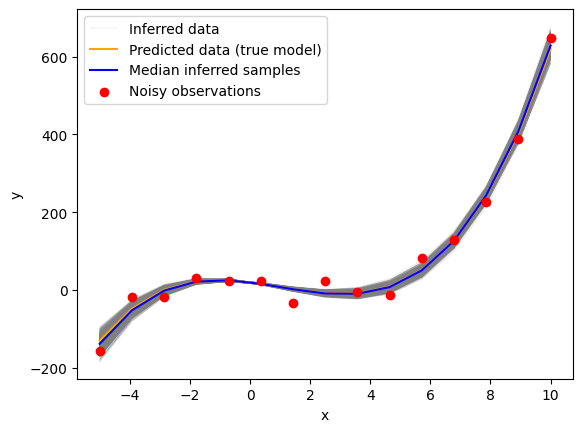

In [23]:
results = inversion.get_results()

coefficients_samples = np.squeeze(np.array([results[f"m{i}"] for i in range(N_DIMS)]))

fig, ax = plt.subplots()
y_pred = np.array(results["dpred"])
ax.plot(DATA_X, y_pred[0], c='gray', lw=0.3, alpha=0.3, label="Inferred data")
ax.plot(DATA_X, y_pred[1:].T, c='gray', lw=0.3, alpha=0.3)
ax.plot(DATA_X, y, c='orange', label='Predicted data (true model)')
ax.plot(DATA_X, np.median(y_pred, axis=0), c="blue", label='Median inferred samples')
ax.scatter(DATA_X, y_noisy, c='r', label='Noisy observations', zorder=3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()

Finally, we create a figure that displays the inferred polynomial coefficients, with yellow dots indicating the true values. This is achieved using the [ArviZ](https://python.arviz.org/en/latest/index.html) library, which provides useful functionalities for plotting inference results.

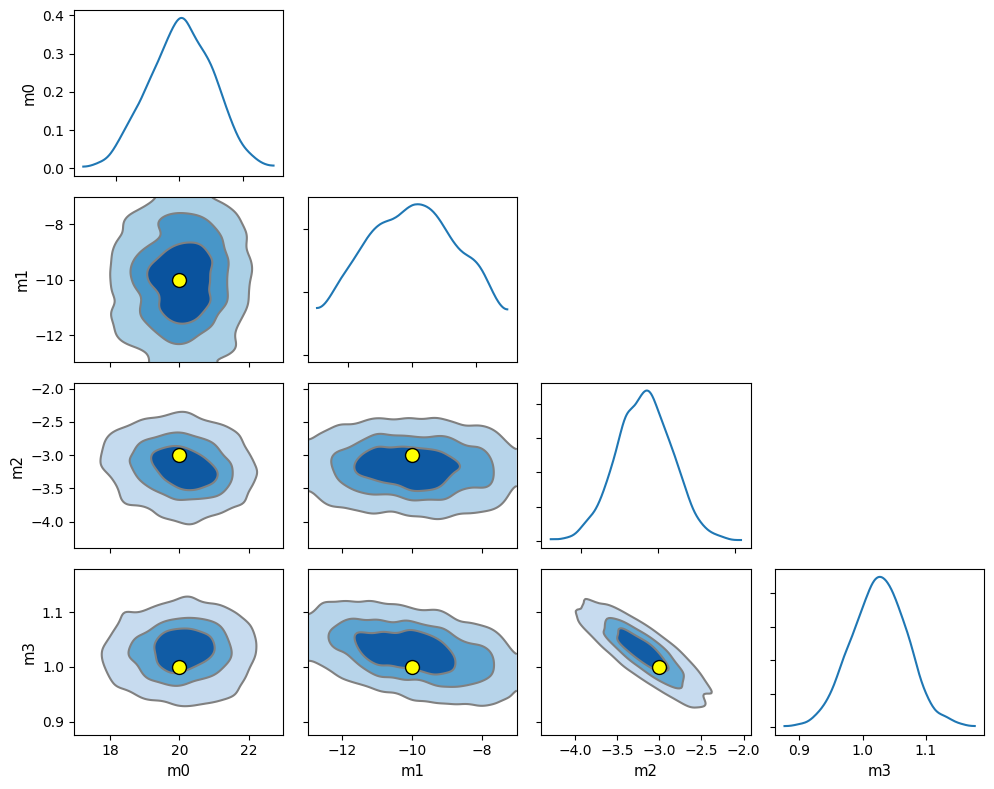

In [24]:
import arviz as az

fig, axes = plt.subplots(4, 4, figsize=(10, 8))
results_coefficients = {k: v for k, v in results.items() if k != 'dpred'}
_ = az.plot_pair(
    results_coefficients,
    marginals=True,
    reference_values={'m0': M0, 'm1': M1, 'm2': M2, 'm3': M3},
    reference_values_kwargs={'color': 'yellow',
                             'ms': 10},
    kind='kde',
    kde_kwargs={
        'hdi_probs': [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        'contourf_kwargs': {'cmap': 'Blues'},
        },
    ax=axes,
    textsize=10
    )
plt.tight_layout()